In [13]:
import numpy as np
import pandas as pd
import os

from tvb.simulator.lab import *
import sys
import scipy.io
import tvbsim

# plotting fxns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# set all directories
root_dir = os.path.join('/Users/adam2392/Documents/pydata/')

patient='id008_gc'
patient ='id013_pg'
expname = 'exp005'
metadatadir = os.path.join(root_dir, "metadata", patient)
outputdatadir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/', expname)
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)

tvbsim.util.renamefiles(patient, metadatadir)

# get the important files
getfilepath = lambda filename: os.path.join(metadatadir, filename)
seegfile = getfilepath('seeg.txt')
gainfile = getfilepath('gain_inv-square.txt')
# surffile = getfilepath

Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!


In [15]:
''' THE REAL CLINICALLY ANNOTATED AREAS '''
#001
if 'id001' in patient:
    ezregions = ['ctx-rh-lateralorbitofrontal', 'ctx-rh-temporalpole']
    pzregions = ['ctx-rh-superiorfrontal', 'ctx-rh-rostralmiddlefrontal', 'ctx-lh-lateralorbitofrontal']

# 008
if 'id008' in patient:
    ezregions = ['Right-Amygdala', 'Right-Hippocampus']
    pzregions = ['ctx-rh-superiortemporal', 'ctx-rh-temporalpole', 'ctx-rh-inferiortemporal',
     'ctx-rh-medialorbitofrontal', 'ctx-rh-lateralorbitofrontal']

# 013
if 'id013' in patient:
    ezregions = ['ctx-rh-fusiform']
    pzregions = ['ctx-rh-inferiortemporal','Right-Hippocampus','Right-Amygdala', 
          'ctx-rh-middletemporal','ctx-rh-entorhinal']

# 014
if 'id014' in patient:
    ezregions = ['Left-Amygdala', 'Left-Hippocampus', 'ctx-lh-entorhinal', 'ctx-lh-fusiform',
         'ctx-lh-temporalpole','ctx-rh-entorhinal']
    pzregions = ['ctx-lh-superiortemporal', 'ctx-lh-middletemporal', 'ctx-lh-inferiortemporal',
         'ctx-lh-insula', 'ctx-lh-parahippocampal']

In [20]:
# initialize structural connectivity and main simulator object
con = connectivity.Connectivity.from_file(os.path.join(metadatadir, "connectivity.zip"))
maintvbexp = tvbsim.MainTVBSim(con, condspeed=3.0)
# load the necessary data files to run simulation
maintvbexp.loadseegxyz(seegfile=seegfile)
maintvbexp.loadgainmat(gainfile=gainfile)
maintvbexp.loadsurfdata(directory=metadatadir, use_subcort=False)

# set ez/pz regions
# pzregions = []
maintvbexp.setezregion(ezregions=ezregions)
maintvbexp.setpzregion(pzregions=pzregions)
print(maintvbexp.ezind)
print(maintvbexp.ezregion)
print(maintvbexp.pzregion)
print(maintvbexp.conn.speed)

NOT USING SUBCORT
[54]
['ctx-rh-fusiform']
['ctx-rh-inferiortemporal' 'Right-Hippocampus' 'Right-Amygdala'
 'ctx-rh-middletemporal' 'ctx-rh-entorhinal']


In [21]:
# setup models and integrators
######### Epileptor Parameters ##########
epileptor_r = 0.00035#/1.5   # Temporal scaling in the third state variable
epiks = -2                  # Permittivity coupling, fast to slow time scale
epitt = 0.05                   # time scale of simulation
epitau = 10                 # Temporal scaling coefficient in fifth st var
x0norm=-2.35 # x0c value = -2.05
x0ez=-1.85
x0pz=-2.2
######### Integrator Parameters ##########
# parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                      0.0001, 0.0001, 0.])
# simulation parameters
_factor = 1
_samplerate = 1000*_factor # Hz
sim_length = 80*_samplerate    
period = 1./_factor

maintvbexp.initepileptor(x0norm=x0norm, x0ez=x0ez, x0pz=None,
                        r=epileptor_r, Ks=epiks, tt=epitt, tau=epitau)
maintvbexp.initintegrator(ts=heun_ts, noise_cov=noise_cov)

In [23]:
dist = -1
for ind in maintvbexp.ezind:
    print(maintvbexp.move_electrodetoreg(ind, dist))   

None
[3.]


In [24]:
# maintvbexp.gain_matrix_inv_square()
configs = maintvbexp.setupsim(a=1., period=period, moved=False)
display(configs)
times, epilepts, seegts = maintvbexp.mainsim(sim_length=sim_length)

initial_conditions,None
coupling,Difference(a=1)
stimulus,None
integrator,"HeunStochastic(dt=0.05, noise=Additive(dt=0.05, ntau=0))"
surface,None
connectivity,"Connectivity(bound=False, value=None)"
conduction_speed,3.0
simulation_length,1000.0
model,"Epileptor(bound=False, value=None)"
monitors,"[TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None)]"


In [25]:
allindices = np.append(maintvbexp.ezind, maintvbexp.pzind, axis=0).astype(int)
secstoreject = 15

postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
times, epits, seegts, zts = postprocessor.postprocts(epilepts, seegts, times, secstoreject=secstoreject)

# get the onsettimes and offsettimes for ez/pz indices
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, delta=0.2/5)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

freqrange = [0.1, 499]
# linefreq = 60

noisemodel = tvbsim.postprocess.filters.FilterLinearNoise(samplerate=_samplerate)
seegts = noisemodel.filter_rawdata(seegts, freqrange)
# seegts = noisemodel.notchlinenoise(seegts, freq=linefreq)
print(seegts.shape)
print(zip(seizonsets,seizoffsets))

returning cuz prevoffset is nan!
(59, 65000)
[(10477.0, 16897.0), (35122.0, 43089.0)]


In [26]:
metadata = {
        'x0ez':x0ez,
        'x0pz':x0pz,
        'x0norm':x0norm,
        'regions': maintvbexp.conn.region_labels,
        'regions_centers': maintvbexp.conn.centres,
        'seeg_contacts': maintvbexp.seeg_labels,
        'seeg_xyz': maintvbexp.seeg_xyz,
        'ez': maintvbexp.ezregion,
        'pz': maintvbexp.pzregion,
        'ezindices': maintvbexp.ezind,
        'pzindices': maintvbexp.ezind,
        'onsettimes':seizonsets,
        'offsettimes':seizoffsets,
        'patient':patient,
        'epiparams': maintvbexp.getepileptorparams()
    }

# if dist != -1:

filename = os.path.join(outputdatadir, 
        patient+'_dist' + str(dist) + '_condelay.npz')
# save tseries
np.savez_compressed(filename, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=metadata)

In [27]:
# # get the onsettimes and offsettimes for ez/pz indices
# postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
# settimes = postprocessor.getonsetsoffsets(zts, allindices, delta=0.2/5)# get the actual seizure times and offsets
# seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

# print(zip(seizonsets,seizoffsets))

[-42.67536441181987, -69.23329261710714, -37.27710946302841, -24.01163586666071, -17.296726081537305, -13.884622935186462, -11.783819991997506, -14.023075285393082, -10.900232817314485, -13.127051265779425, -14.017426410916082, -15.230627483904195, -16.585186789937502, -13.740885262549847, -12.634782810165309, -12.759962793964574, -16.055666814333122, -18.090959006527445, -21.388997822934694, -24.75505084233167, -27.563926746468418, -26.773005053208546, -22.473159913024507, -18.87158615728358, -16.090470689766686, -13.820665163659326, -47.87852522577256, -53.727653295746585, -56.272015045496275, -31.440631163925335, -22.787349075040655, -18.887645378174152, -20.99891432425423, -14.401957065268089, -12.663324474230523, -12.460790473102964, -11.71227138290579, -11.03023695097395, -10.466707167291581, -10.722467142744554, -11.080899601395592, -8.321212632109823, -8.422365132545387, -8.440251811406196, -8.388805925591692, -9.42909846575542, -10.094918775202123, -9.920511367294516, -9.50537

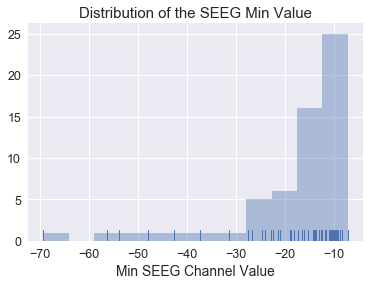

In [72]:
sigvals = []
for idx, sig in enumerate(seegts):
    sigvals.append(np.min(sig))

print(sigvals)
    
fig = plt.figure()
sns.set(font_scale=1.25)
sns.distplot(sigvals, kde=False, rug=True,
             axlabel='Min SEEG Channel Value')
plt.title('Distribution of the SEEG Min Value')
ax = plt.gca()
# ax.set_xticks(np.arange(0,60,5))

# Apply Visualization of The Data

In [28]:
brainplotter = tvbsim.visualize.plotbrain.VisualBrain()
brainplotter.setfigsize(figsize=(20,17))
brainplotter.loadsurf(maintvbexp.vertices)
brainplotter.loadseeg(maintvbexp.seeg_xyz, maintvbexp.seeg_labels)
brainplotter.loadregs(maintvbexp.conn.centres, maintvbexp.conn.region_labels)
brainplotter.setcontacts()

Nbre_contacts_per_electrode: [9, 6, 11, 9, 6, 9, 9]
Nbre_electrodes: 7
Ending Index of electrodes: [ 9 15 26 35 41 50 59]


id013_pg
num regions:  84
num contacts:  59
7
xreg:  (84,)
yreg:  (84,)
zreg:  (84,)


(<matplotlib.figure.Figure at 0x118ae8410>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11409b310>)

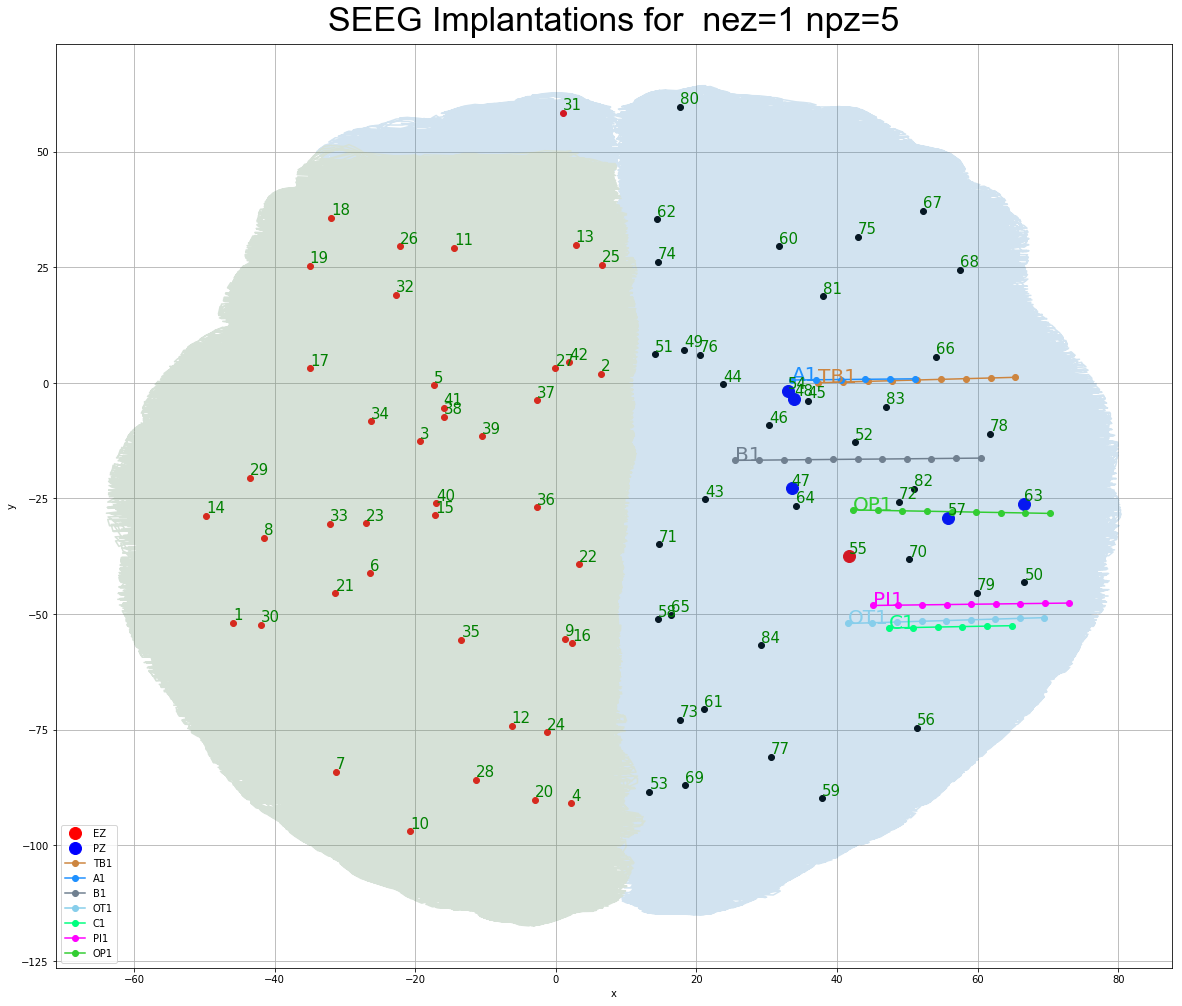

In [29]:
print(patient)
brainplotter.plotcontactsinbrain(maintvbexp.ezind, maintvbexp.pzind)

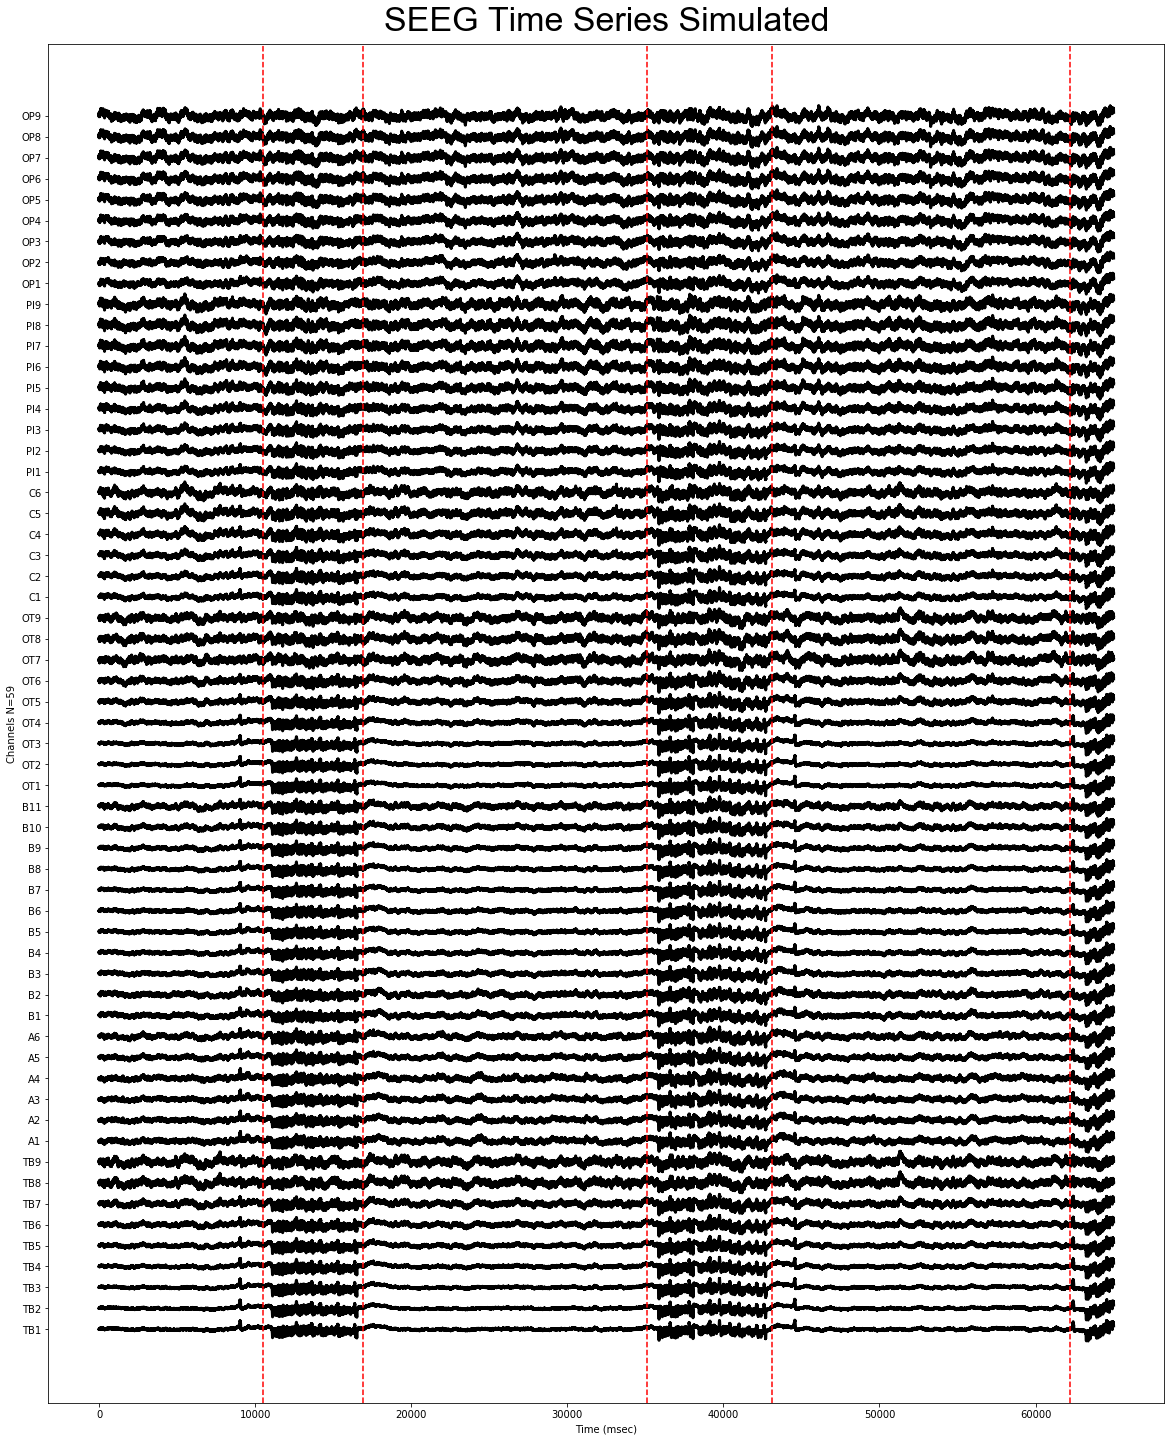

In [30]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=seegts,ylabels=maintvbexp.seeg_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True)
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
# tsviz.colorts(maintvbexp.ezind, color=colors[0])

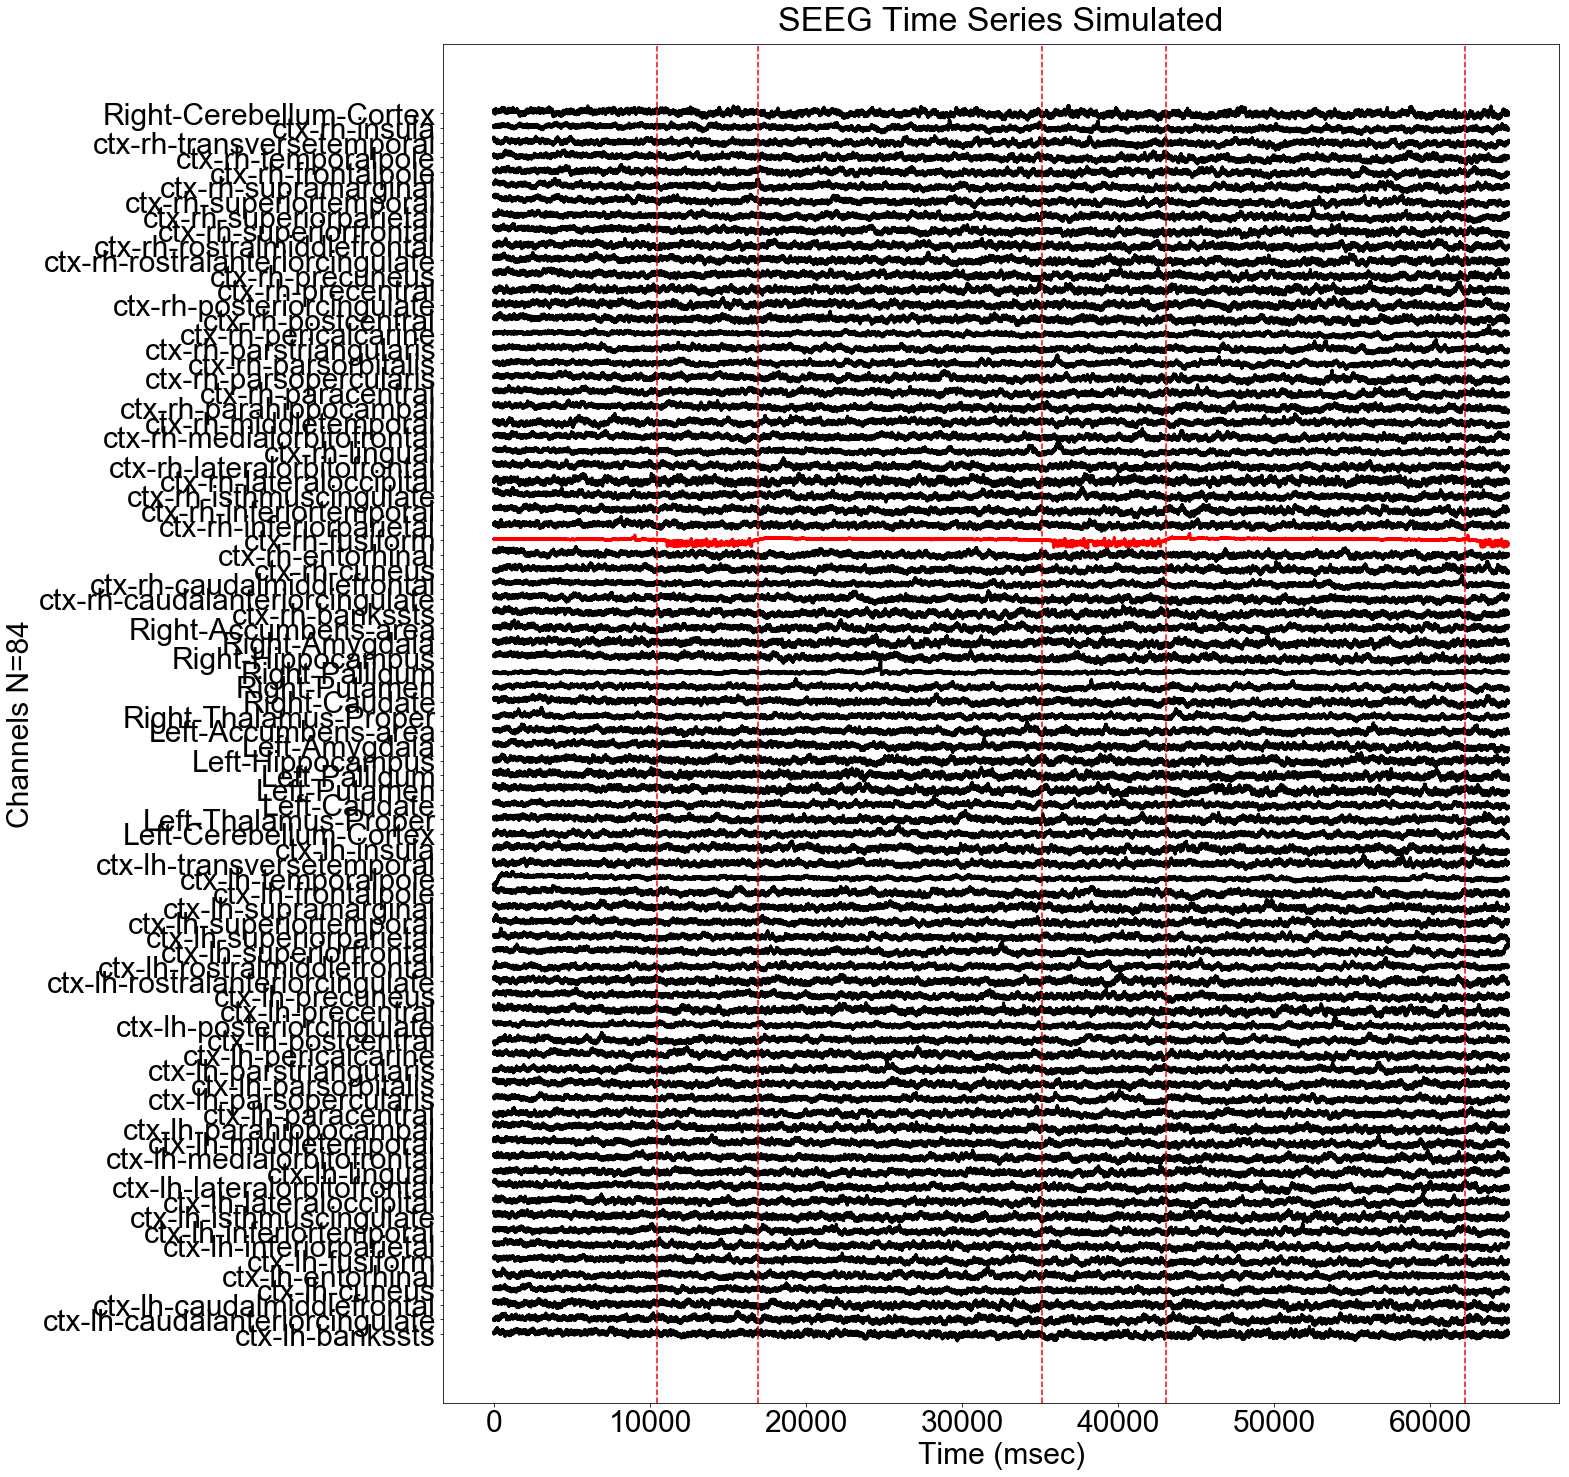

In [31]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=epits,ylabels=maintvbexp.conn.region_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True)
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
tsviz.colorts(maintvbexp.ezind, color='red')

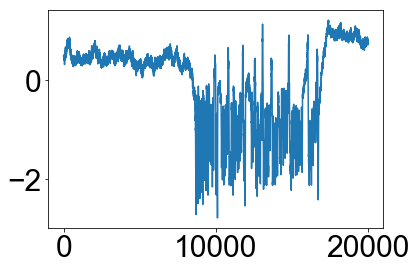

In [38]:
plt.plot(epits[maintvbexp.ezind[0],5000:25000])

In [ ]:
print(maintvbexp.conn.centres[maintvbexp.ezind])
for ind in maintvbexp.ezind:
    print(maintvbexp.findclosestcontact(ind))

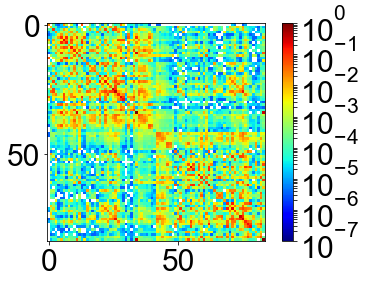

In [35]:
from matplotlib import colors, cm
plt.figure()
image = maintvbexp.conn.weights
norm = colors.LogNorm(1e-7, image.max()) #, clip='True')
plt.imshow(image, norm=norm, cmap=cm.jet)
plt.colorbar()
#max(con.weights[con.weights != 0])